# PINNsFormer - Transient Lid-driven Cavity Flow

---

This notbook solves a special case of the Navier-Stokes equations, the lid-driven cavity flow. More precisely the transient lid driven cavity flow. It is an important system for the study of incompressible flows and it is also used as an benchmark for numerical methods. The following example was based on [Ghia et al. 1982](https://doi.org/10.1016/0021-9991(82)90058-4) with the addition of a timeframe and initial conditions. The solution is then evaluated at its stability state, when $\mathbf{t}=\mathbf{t_f}$.
 
Considering the Navier-Stokes equation: 

$$\frac{\partial\mathbf{u}}{\partial\mathbf{t}} + \mathbf{u}\cdot\nabla \mathbf{u}=-\nabla p + \frac{1}{Re}\Delta \mathbf{u}$$

and the continuity equation:

$$\nabla \cdot \mathbf{u}=0,$$ 

Let $\mathbf{Re}=100$, $\mathbf{u}=(u,v,t)$ the velocity vector field and $\mathbf{p}$ the pressure. 

The domain is the rectangle $[0,1]^2$ with the following Dirichlet boundary conditions:

- Left, right and bottom walls
$$
u(0,y,t)=u(x,0,t)=u(1,y,t)=v(0,y,t)=v(x,0,t)=v(1,y,t)=v(x,1,t)=0
$$

- Top wall (lid):
$$
u(x,1,t)=1
$$

- Pressure
$$
p(0,0,t)=0
$$

The time interval is $[0, 1]$ with the following initial condtions:
$$
    u(x,y,0)=0 \qquad u(x,y,0)=0
$$


### Libraries used

In [2]:
import numpy as np
import torch
from torch import autograd
import torch.nn as nn
import matplotlib.pyplot as plt
import random
from torch.optim import LBFGS, Adam
from tqdm import tqdm
import scipy.io

from util import *
from plot import test_and_plot_graphs, plot_loss_evolution

from PINNsFormer import PINNsformer

### For experiments reproductibility

In [3]:
seed = 0
np.random.seed(seed)
random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using {device} device")

Using cpu device


### Domain boundaries, Coeficient values and parameters

In [4]:
Re = 100 # Reinolds number
LID_VELOCITY = 1

x0, xf = 0, 1
y0, yf = 0, 1
t0, tf = 0, 2

x_sample_size = 10
y_sample_size = 10
t_sample_size = 5

res_lw = 1
bc_lw = 1
ic_lw = 1

NUM_OF_EPOCHS = 5

# Additional parameters for the pseudo-sequence generator
k_steps_foward = 2
step_size = 1e-4

### Defining the problem

In [5]:
# Sampling data training points
res, b_left, b_right, b_upper, b_lower = get_data_3d([x0, xf], [y0, yf], [t0, tf], x_sample_size, y_sample_size, t_sample_size)

# Creating pseudo-sequences
res = make_time_sequence(res, k_steps_foward, step_size)
b_left = make_time_sequence(b_left, k_steps_foward, step_size)
b_right = make_time_sequence(b_right, k_steps_foward, step_size)
b_upper = make_time_sequence(b_upper, k_steps_foward, step_size)
b_lower = make_time_sequence(b_lower, k_steps_foward, step_size)

# Convert data to tensors, move to device, and set requires_grad as needed
res = torch.tensor(res, dtype=torch.float32, requires_grad=True).to(device)
b_left = torch.tensor(b_left, dtype=torch.float32, requires_grad=True).to(device)
b_right = torch.tensor(b_right, dtype=torch.float32, requires_grad=True).to(device)
b_upper = torch.tensor(b_upper, dtype=torch.float32, requires_grad=True).to(device)
b_lower = torch.tensor(b_lower, dtype=torch.float32, requires_grad=True).to(device)

# Extract coordinates
x_res, y_res, t_res = res[:,:,0:1], res[:,:,1:2], res[:,:,2:3]
x_left, y_left, t_left = b_left[:,:,0:1], b_left[:,:,1:2], b_left[:,:,2:3]
x_right, y_right, t_right = b_right[:,:,0:1], b_right[:,:,1:2], b_right[:,:,2:3]
x_upper, y_upper, t_upper = b_upper[:,:,0:1], b_upper[:,:,1:2], b_upper[:,:,2:3]
x_lower, y_lower, t_lower = b_lower[:,:,0:1], b_lower[:,:,1:2], b_lower[:,:,2:3]

### Defining the model

In [6]:
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

model = PINNsformer(d_out=3, d_hidden=125, d_model=32, N=1, heads=2).to(device)
model.apply(init_weights)
optim = LBFGS(model.parameters(), line_search_fn='strong_wolfe')
# optim = Adam(model.parameters())

n_params = get_n_params(model)

print(model)
print(get_n_params(model))

PINNsformer(
  (linear_emb): Linear(in_features=3, out_features=32, bias=True)
  (encoder): Encoder(
    (layers): ModuleList(
      (0): EncoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequential(
            (0): Linear(in_features=32, out_features=256, bias=True)
            (1): WaveAct()
            (2): Linear(in_features=256, out_features=256, bias=True)
            (3): WaveAct()
            (4): Linear(in_features=256, out_features=32, bias=True)
          )
        )
        (act1): WaveAct()
        (act2): WaveAct()
      )
    )
    (act): WaveAct()
  )
  (decoder): Decoder(
    (layers): ModuleList(
      (0): DecoderLayer(
        (attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=32, out_features=32, bias=True)
        )
        (ff): FeedForward(
          (linear): Sequen

In [7]:
# loss_track = []

# for i in tqdm(range(NUM_OF_EPOCHS)):
    
#     def closure():

#         pred_res = model(x_res, y_res, t_res)
#         pred_left = model(x_left, y_left, t_left)
#         pred_right = model(x_right, y_right, t_right)
#         pred_upper = model(x_upper, y_upper, t_upper)
#         pred_lower = model(x_lower, y_lower, t_lower)


#         u, v, p = pred_res[:, :, 0:1], pred_res[:, :, 1:2], pred_res[:, :, 2:3]
#         #u, v, p = pred_res[:, 0:1], pred_res[:, 1:2], pred_res[:, 2:3]

        
#         # First derivates
#         du_x = autograd.grad(u, x_res, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
#         du_y = autograd.grad(u, y_res, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
#         du_t = autograd.grad(u, t_res, grad_outputs=torch.ones_like(u), retain_graph=True, create_graph=True)[0]
        
#         dv_x = autograd.grad(v, x_res, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
#         dv_y = autograd.grad(v, y_res, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]
#         dv_t = autograd.grad(v, t_res, grad_outputs=torch.ones_like(v), retain_graph=True, create_graph=True)[0]

#         dp_x = autograd.grad(p, x_res, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]
#         dp_y = autograd.grad(p, y_res, grad_outputs=torch.ones_like(p), retain_graph=True, create_graph=True)[0]

        
#         # Compute second derivatives for viscous term
#         dv_xx = autograd.grad(dv_x, x_res, grad_outputs=torch.ones_like(dv_x), retain_graph=True, create_graph=True)[0]
#         dv_yy = autograd.grad(dv_y, y_res, grad_outputs=torch.ones_like(dv_y), retain_graph=True, create_graph=True)[0]
        
#         du_xx = autograd.grad(du_x, y_res, grad_outputs=torch.ones_like(du_x), retain_graph=True, create_graph=True)[0]
#         du_yy = autograd.grad(du_x, y_res, grad_outputs=torch.ones_like(du_y), retain_graph=True, create_graph=True)[0]

        
#         # Navier-Stokes equations
#         momentum_x = du_t + u * du_x + v * du_y + dp_x - (1 / Re) * (du_xx + du_yy)
#         momentum_y = dv_t + u * dv_x + v * dv_y + dp_y - (1 / Re) * (dv_xx + dv_yy)
#         continuity = du_x + dv_y

        
#         # Compute PDE residuals
#         pde_residual = torch.mean(momentum_x**2 + momentum_y**2 + continuity**2)


#         u_left, v_left = pred_left[:, :, 0:1], pred_left[:, :, 1:2]
#         u_right, v_right = pred_right[:, :, 0:1], pred_right[:, :, 1:2]
#         u_upper, v_upper = pred_upper[:, :, 0:1], pred_upper[:, :, 1:2]
#         u_lower, v_lower = pred_lower[:, :, 0:1], pred_lower[:, :, 1:2]
#         p_lower = pred_lower[:, :, 2:3]

        
#         bc_left_u = torch.mean((u_left)**2)
#         bc_left_v = torch.mean((v_left)**2)

#         bc_right_u = torch.mean((u_right)**2)
#         bc_right_v = torch.mean((v_right)**2)

#         bc_upper_u = torch.mean((u_upper - LID_VELOCITY)**2) # Lid -> u(x,1,t)=1
#         bc_upper_v = torch.mean((v_upper)**2)

#         # Lower wall boundary conditions
#         bc_lower_u = torch.mean((u_lower)**2)
#         bc_lower_v = torch.mean((v_lower)**2)

#         # Pressure boundary condition
#         bc_p = torch.mean(p_lower**2) # p(0, 0, t) = 0

#         # Initial conditions
#         initial_mask = torch.isclose(t_res[:,0,0], torch.tensor(0.0))
        
#         ic_u = torch.mean((u[initial_mask])**2)
#         ic_v = torch.mean((v[initial_mask])**2)

        
#         # Total loss
#         loss =  (pde_residual) * res_lw
#         #loss += (bc_left_u + bc_left_v + bc_right_u + bc_right_v + bc_upper_u + bc_upper_v + bc_lower_u + bc_lower_v + bc_p) * bc_lw
#         #loss += (ic_u + ic_v) * ic_lw

#         loss_track.append(loss.item())

#         optim.zero_grad()
#         loss.backward()
        
#         return loss

#     optim.step(closure)

### Training the model

In [8]:
loss_track = []

def compute_derivatives(var, inputs):
    return [autograd.grad(var, inp, grad_outputs=torch.ones_like(var), retain_graph=True, create_graph=True)[0] for inp in inputs]

def compute_second_derivatives(deriv, inp):
    return autograd.grad(deriv, inp, grad_outputs=torch.ones_like(deriv), retain_graph=True, create_graph=True)[0]

for epoch in tqdm(range(NUM_OF_EPOCHS)):
    
    def closure():

        pred_res = model(x_res, y_res, t_res)
        pred_left = model(x_left, y_left, t_left)
        pred_right = model(x_right, y_right, t_right)
        pred_upper = model(x_upper, y_upper, t_upper)
        pred_lower = model(x_lower, y_lower, t_lower)


        u, v, p = pred_res[:, :, 0:1], pred_res[:, :, 1:2], pred_res[:, :, 2:3]
        #u, v, p = pred_res[:, 0:1], pred_res[:, 1:2], pred_res[:, 2:3]

        
        # First derivates
        du_x, du_y, du_t = compute_derivatives(u, [x_res, y_res, t_res])
        dv_x, dv_y, dv_t = compute_derivatives(v, [x_res, y_res, t_res])
        dp_x, dp_y = compute_derivatives(p, [x_res, y_res])

        
        # Compute second derivatives for viscous term
        du_xx = compute_second_derivatives(du_x, x_res)
        du_yy = compute_second_derivatives(du_y, y_res)
        dv_xx = compute_second_derivatives(dv_x, x_res)
        dv_yy = compute_second_derivatives(dv_y, y_res)

        
        # Navier-Stokes equations
        momentum_x = du_t + u * du_x + v * du_y + dp_x - (1 / Re) * (du_xx + du_yy)
        momentum_y = dv_t + u * dv_x + v * dv_y + dp_y - (1 / Re) * (dv_xx + dv_yy)
        continuity = du_x + dv_y

        
        # Compute PDE residuals
        pde_residual = torch.mean(momentum_x**2 + momentum_y**2 + continuity**2)


        u_left, v_left = pred_left[:, :, 0:1], pred_left[:, :, 1:2]
        u_right, v_right = pred_right[:, :, 0:1], pred_right[:, :, 1:2]
        u_upper, v_upper = pred_upper[:, :, 0:1], pred_upper[:, :, 1:2]
        u_lower, v_lower = pred_lower[:, :, 0:1], pred_lower[:, :, 1:2]
        p_lower = pred_lower[:, :, 2:3]

        
        bc_left_u = torch.mean((u_left)**2)
        bc_left_v = torch.mean((v_left)**2)

        bc_right_u = torch.mean((u_right)**2)
        bc_right_v = torch.mean((v_right)**2)

        bc_upper_u = torch.mean((u_upper - LID_VELOCITY)**2) # Lid -> u(x,1,t)=1
        bc_upper_v = torch.mean((v_upper)**2)

        # Lower wall boundary conditions
        bc_lower_u = torch.mean((u_lower)**2)
        bc_lower_v = torch.mean((v_lower)**2)

        # Pressure boundary condition
        bc_p = torch.mean(p_lower**2) # p(0, 0, t) = 0

        # Initial conditions
        initial_mask = torch.isclose(t_res[:,0,0], torch.tensor(0.0))
        
        ic_u = torch.mean((u[initial_mask])**2)
        ic_v = torch.mean((v[initial_mask])**2)

        
        # Total loss
        loss =  (pde_residual) * res_lw
        loss += (bc_left_u + bc_left_v + bc_right_u + bc_right_v + bc_upper_u + bc_upper_v + bc_lower_u + bc_lower_v + bc_p) * bc_lw
        loss += (ic_u + ic_v) * ic_lw

        # loss_track.append(loss.item()) # For a cleaner visualization, the loss values will be added after each epoch instead of after each iteration

        optim.zero_grad()
        loss.backward()
        
        return loss

    loss = optim.step(closure)  # Runs the closure and returns the loss
    loss_track.append(loss.item())  # Appends loss once per epoch

100%|██████████| 5/5 [01:21<00:00, 16.23s/it]


### Saving model and losses

In [9]:
torch.save(model, "./models/pinnsformer")
torch.save(model.state_dict(), "./models/pinnsformer-sd.pt")
np.save("./losses/pinnsformer.npy", loss_track)

### Visualizing results

If you want to visualize the predicted values but you want to skip the training phase, just run the cells bellow. But don't forget to run the import cell before.

In [10]:
model = torch.load("models/pinnsformer", weights_only=False)
loss_track = np.load("losses/pinnsformer.npy")

In [11]:
loss_track[-1]

0.3474027216434479

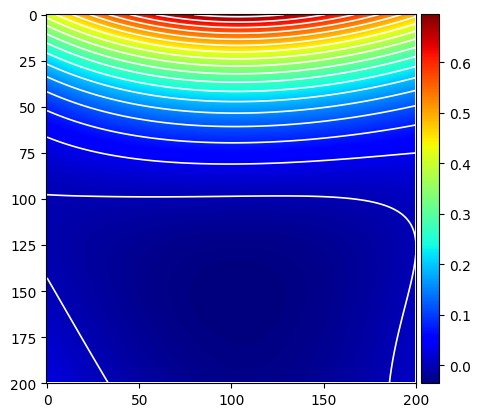

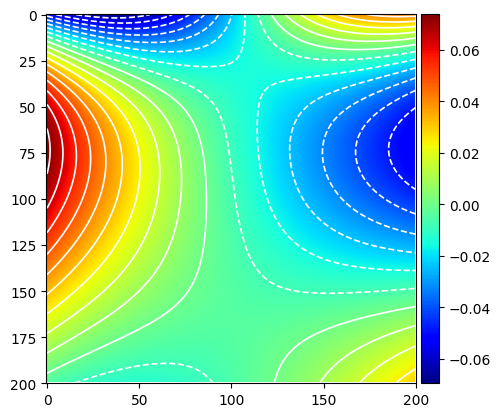

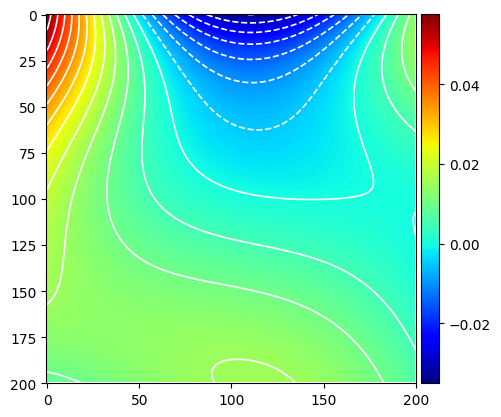

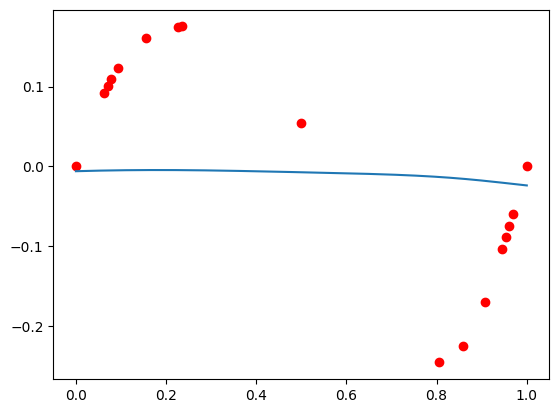

In [12]:
test_and_plot_graphs(model, device, k_steps_foward=k_steps_foward, step_size=step_size)

### Loss evolution

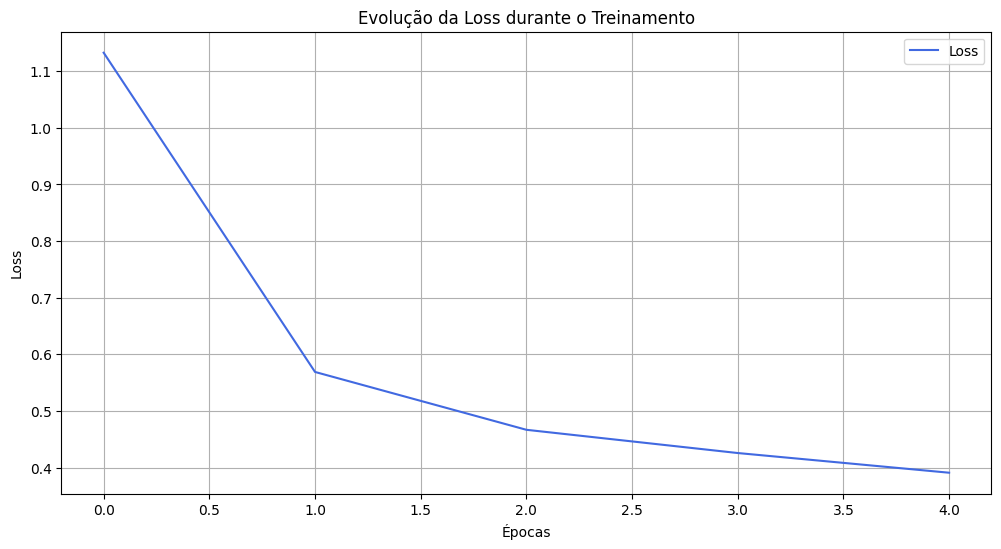

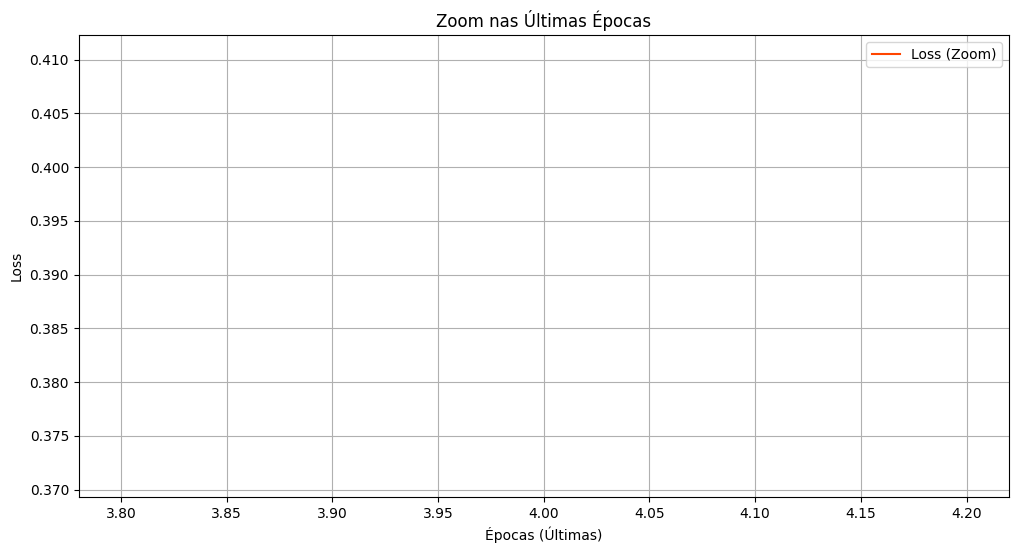

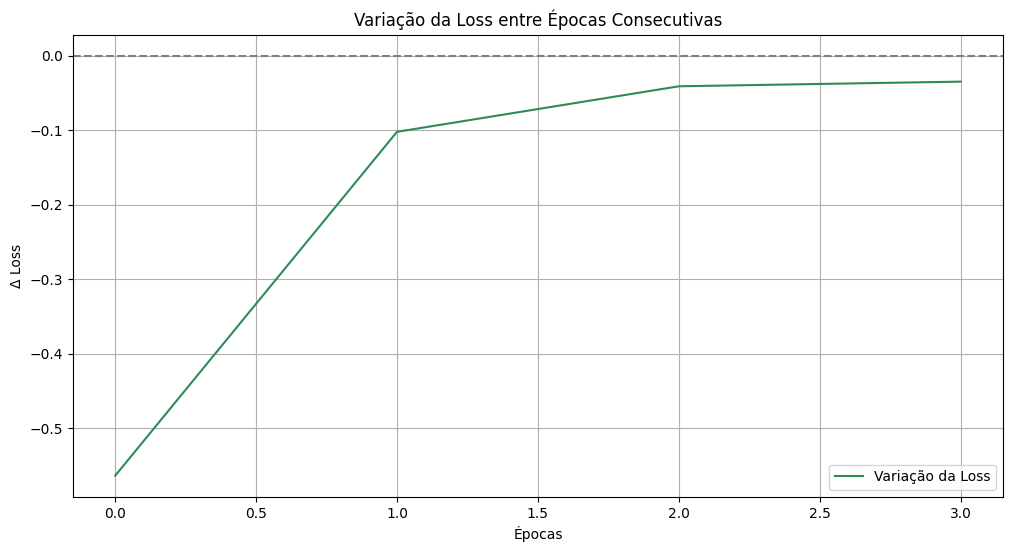

In [13]:
plot_loss_evolution('./losses/pinns.npy')